In [30]:
import numpy as np
import pandas as pd
import nltk
import string
import re
stopwords=nltk.corpus.stopwords.words('english')
ps=nltk.PorterStemmer()


In [31]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [32]:
def text_cleaning(data):
  clean_text="".join([char for char in data if char not in string.punctuation])
  tokens=re.split('\W+',clean_text)
  text=[ps.stem(word) for word in tokens if word not in stopwords] #use " ".join() when using ngrams
  return text

**Vectorizing the raw data(using N grams)**
it creates a document term matrix where counts still occupy the cell with combinations of adjacent words of length "n" in the text

In [56]:
df=pd.read_csv('/content/drive/My Drive/SMSSpamCollection.tsv',sep='\t',header=None)
df.columns=['label','text']
df['cleaned_text']=df['text'].apply(lambda x:text_cleaning(x))
df['cleaned_text']
df['map_label']=df['label'].apply(lambda x:1 if x=='ham' else 0)
df['map_label'].head()

0    1
1    0
2    1
3    1
4    1
Name: map_label, dtype: int64

**Apply N-gram vectorizer using sklearn.features_extraction_text**

In [9]:
from sklearn.feature_extraction.text import CountVectorizer

In [12]:
ngram_vect=CountVectorizer(ngram_range=[2,2])
x_counts=ngram_vect.fit_transform(df['cleaned_text'])
print(x_counts.shape)
#ngram_vect.get_feature_names()

(5568, 34129)


In [13]:
data=pd.DataFrame(x_counts.toarray())
data.columns=ngram_vect.get_feature_names()
data.head(2)

,008704050406 sp,0089mi last,0121 2025050,01223585236 xx,01223585334 cum,0125698789 ring,02 user,020603 2nd,020603 thi,0207 153,02072069400 bx,02073162414 cost,02085076972 repli,020903 thi,021 3680,021 3680offer,050703 tcsbcm4235wc1n3xx,06 good,07046744435 arrang,07090298926 reschedul,07099833605 reschedul,07123456789 87077,0721072 find,07732584351 rodger,07734396839 ibh,07742676969 show,07753741225 show,0776xxxxxxx uve,077xxx won,07801543489 guarante,07808 xxxxxx,07808247860 show,07808726822 award,07815296484 show,0784987 show,0789xxxxxxx today,0796xxxxxx today,07973788240 show,07xxxxxxxxx 2000,07xxxxxxxxx show,...,yup hope,yup how,yup im,yup ive,yup izzit,yup leav,yup lunch,yup msg,yup need,yup next,yup ok,yup paragon,yup send,yup shd,yup song,yup studi,yup thk,yup tri,yup wun,yupz ive,ywhere at,zac doesnt,zaher got,zebra anim,zed 08701417012,zed 08701417012150p,zed pobox,zero that,zhong se,zindgi wo,zoe 18,zoe it,zogtoriu stare,zoom cine,zouk with,zyada kisi,üll finish,üll submit,üll take,〨ud even
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


TF-IDF Equation w(i,j)=tf(i,j)*log(N/df(i))
tf(i,j)=number of times i occur in j divided by total number of terms in j.
df(i) number of documents containing i,N :total number of documents
documents is the text basically in case of confusion

**Apply tfidVectorizer using sklearn**

In [33]:
df_1=pd.read_csv('/content/drive/My Drive/SMSSpamCollection.tsv',sep='\t',header=None)
df_1.columns=['label','text']
df_1['cleaned_text']=df['text'].apply(lambda x:text_cleaning(x))
df_1['cleaned_text'].head(2)


0    [ive, search, right, word, thank, breather, I,...
1    [free, entri, 2, wkli, comp, win, FA, cup, fin...
Name: cleaned_text, dtype: object

In [34]:
from sklearn.feature_extraction.text import  TfidfVectorizer


In [35]:
tfid_vect=TfidfVectorizer(analyzer=text_cleaning)
x_tfidf=tfid_vect.fit_transform(df_1['text'])
print(x_tfidf.shape)

(5568, 8337)


In [36]:
new_df=pd.DataFrame(x_tfidf.toarray())
new_df.columns=tfid_vect.get_feature_names()
new_df.head()


,,0,008704050406,0089mi,0121,01223585236,01223585334,0125698789,02,020603,0207,02070836089,02072069400,02073162414,02085076972,020903,021,050703,0578,06,060505,061104,07008009200,07046744435,07090201529,07090298926,07099833605,071104,07123456789,0721072,07732584351,07734396839,07742676969,07753741225,0776xxxxxxx,07786200117,077xxx,078,07801543489,07808,...,yourself,youso,youthat,youto,youuuuu,youv,youwanna,youwhen,yovil,yowif,yoyyooo,yr,ystrdayic,yummi,yummmm,yun,yunni,yuo,yuou,yup,yupz,ywhere,zac,zaher,zealand,zebra,zed,zero,zhong,zindgi,zoe,zogtoriu,zoom,zouk,zyada,Ü,é,ü,üll,〨ud
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**Feature Engineering**
creating useful features needed for model

In [41]:

#creating feature which include the length of the text messages
df['text_length']=df['text'].apply(lambda x:len(x)-x.count(" ")) #count is used to count the number of white space in the string
df['text_length']

0       160
1       128
2        49
3        62
4        28
       ... 
5563    131
5564     29
5565     48
5566    100
5567     21
Name: text_length, Length: 5568, dtype: int64

In [45]:
#creating a newfeature whcih include the number of punctuations in the mesages , this helps in detecting spam 
#or ham mesages
def count_punct(text):
  count=len([char for char in text if char  in string.punctuation])
  return round(count/(len(text)-text.count(" ")),3)*100
df['pun_count']=df['text'].apply(lambda x:count_punct(x))
df['pun_count'].head()

0    2.5
1    4.7
2    4.1
3    3.2
4    7.1
Name: pun_count, dtype: float64

In [46]:
import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Text(0.5, 1.0, 'text_length distribution')

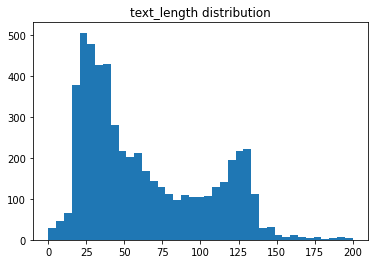

In [47]:
bins=np.linspace(0,200,40)
plt.hist(df['text_length'],bins)
plt.title('text_length distribution')

Text(0.5, 1.0, 'pun_length distribution')

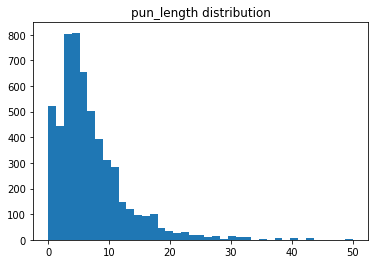

In [48]:
bins=np.linspace(0,50,40)
plt.hist(df['pun_count'],bins)
plt.title('pun_length distribution')

**Transformation**
Process that alter each datapoint in a certain column in a systematic way (eg x*x,squareroot(x))

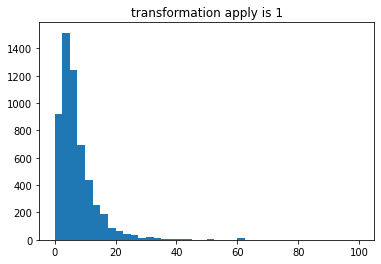

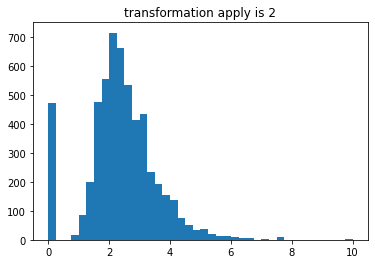

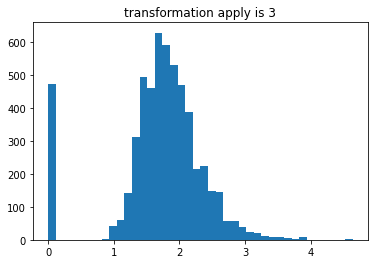

In [49]:
#needed to do transformation beacase the pun_len column is left skewed
#performing box-cox transformation
for i in [1,2,3]:
  plt.hist(df['pun_count']**(1/i),bins=40)
  plt.title("transformation apply is {}".format(str(i)))
  plt.show()

**Machine Learning on data preprocessed**

In [50]:
#1/4 is transformation is best to take
dataframe=pd.concat([df['text_length'],df['pun_count'],new_df],axis=1)
dataframe.head()

,text_length,pun_count,,0,008704050406,0089mi,0121,01223585236,01223585334,0125698789,02,020603,0207,02070836089,02072069400,02073162414,02085076972,020903,021,050703,0578,06,060505,061104,07008009200,07046744435,07090201529,07090298926,07099833605,071104,07123456789,0721072,07732584351,07734396839,07742676969,07753741225,0776xxxxxxx,07786200117,077xxx,078,...,yourself,youso,youthat,youto,youuuuu,youv,youwanna,youwhen,yovil,yowif,yoyyooo,yr,ystrdayic,yummi,yummmm,yun,yunni,yuo,yuou,yup,yupz,ywhere,zac,zaher,zealand,zebra,zed,zero,zhong,zindgi,zoe,zogtoriu,zoom,zouk,zyada,Ü,é,ü,üll,〨ud
0,160,2.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,128,4.7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,49,4.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,62,3.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,28,7.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [52]:
#using random forest as a classifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold,cross_val_score

In [60]:
rf=RandomForestClassifier(n_jobs=-1)
KFold(n_splits=5)
cross_val_score(rf,dataframe,df['map_label'],cv=5,scoring="accuracy",n_jobs=-1)

array([0.97755835, 0.97396768, 0.97486535, 0.96765499, 0.97394429])

In [69]:
#random forest with holdout set
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.model_selection import train_test_split

In [64]:
#train and test split of a dataset with 20% data used for training
(x_train,x_text,y_train,y_test)=train_test_split(dataframe,df['map_label'],test_size=0.2)
rf=RandomForestClassifier(n_estimators=40,n_jobs=-1,max_depth=20)
rf_model=rf.fit(x_train,y_train)

In [65]:
#print this see to which are the important features that contribute in the model buliding
sorted(zip(rf_model.feature_importances_,x_train.columns),reverse=True)[0:10]

[(0.0471459763646528, 'txt'),
 (0.03475706269406497, 'text_length'),
 (0.032223421021170304, 'call'),
 (0.031100303596405587, 'prize'),
 (0.030349691923450033, 'mobil'),
 (0.025564591825551736, 'claim'),
 (0.02060530681619868, 'award'),
 (0.020172294536678466, 'servic'),
 (0.018191130350858693, 'tone'),
 (0.016609281265826864, '500')]

In [73]:
y_pred=rf_model.predict(x_text)
(precision,recall,fscore,support)=score(y_test,y_pred,pos_label=1,average='binary')
print("precision:{} /Recall:{} /Accuracy:{}".format(precision,recall,(y_pred==y_test).sum()/len(y_pred)))

precision:0.9315068493150684 /Recall:1.0 /Accuracy:0.9371633752244165
